In [2]:
from imageai.Detection import ObjectDetection
import os

execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.0.1.h5"))
detector.loadModel()
custom_objects = detector.CustomObjects(bottle=True)
detections = detector.detectCustomObjectsFromImage(input_image=os.path.join(execution_path , "bottle.jpg"), output_image_path=os.path.join(execution_path , "bottle_detection.png"), custom_objects=custom_objects, minimum_percentage_probability=65)


for eachObject in detections:
   print(eachObject["name"] + " : " + eachObject["percentage_probability"] )
   print("--------------------------------")

bottle : 93.76860857009888
--------------------------------
bottle : 97.5142776966095
--------------------------------
bottle : 97.390216588974
--------------------------------


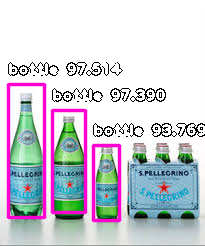

In [3]:
from IPython.display import Image
Image("bottle_detection.png")